In [1]:
! pip install transformers
# ! pip install transformers<4.38
# ! pip install tensorflow==2.11.0 keras==2.11.0

In [2]:
! pip install requests zipfile

ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


In [22]:
import os
import re
import json
import random
import zipfile
import requests
import numpy as np
import pandas as pd
import urllib.request
from tqdm import tqdm
import tensorflow as tf
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFGPT2Model, TFAutoModel
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [40]:
def data_import(data_name):
    data_path = os.getenv('HOME')+'/aiffel/project_data/dlthon/'+data_name
    imported_data = pd.read_csv(data_path)
    return imported_data

def convert_label(data):
    label_map = {'협박 대화': 0, '갈취 대화': 1, '직장 내 괴롭힘 대화': 2, '기타 괴롭힘 대화': 3, '일반 대화': 4}
    
    data['class'] = data['class'].map(label_map)
    return data

In [10]:
violent_data = data_import('train_arg.csv')
violent_data = violent_data.drop('idx', axis=1)
aug_data_a = violent_data[violent_data['data_type'] == '증강 데이터'].drop('data_type', axis=1)
train_data = violent_data[violent_data['data_type'] == '원본 데이터'].drop('data_type', axis=1)
nomal_data = data_import('preprocessed_train_raw.csv')
nomal_data = nomal_data[nomal_data['class'] == 4]
nomal_data['class'] = nomal_data['class'].map({4 : '일반 대화'})
nomal_data = nomal_data.sample(20000)
nomal_data = nomal_data.drop('Unnamed: 0', axis=1)
nomal_data = nomal_data[['class', 'conversation']]

In [11]:
violent_data

,class,conversation,data_type
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,원본 데이터
1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,원본 데이터
2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,원본 데이터
3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,원본 데이터
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,원본 데이터
...,...,...,...
11825,직장 내 괴롭힘 대화,씨\n네 과장님!\n연차를 쓸거면 육하원칙에\n예?\n언제 몰라요? 어디서 써야할거...,증강 데이터
11826,직장 내 괴롭힘 대화,했어? 정희씨 시킨 내가\n아니요 잠시 일좀\n무슨일?\n부탁해서요 기획팀에서 확인...,증강 데이터
11827,직장 내 괴롭힘 대화,있어요? 내일에 지연씨 약속\n없습니다.\n잘됐네. 연차 나랑 내일\n때 다녀올 생...,증강 데이터
11828,직장 내 괴롭힘 대화,놀러왓냐 하사원 여기\n아닙니다\n이것밖에 못햇냐\n죄송해요\n월급만 축내네 진짜\...,증강 데이터


In [12]:
aug_data_a

,class,conversation
3950,협박 대화,스스로를 너 지금 애원하는 죽여달라고 것인가?\n아닙니다. 죄송합니다.\n죽을 거면...
3951,협박 대화,길동경찰서입니다.\n설치할거다. 40분 폭발물을 마트에 9시\n네?\n똑바로 들어 ...
3952,기타 괴롭힘 대화,남자는 되게 나보다 알지? 귀여운거 작은 너 첨봤어.\n놀리는거 니들 재미없어. 그...
3953,갈취 대화,어이 거기\n예??\n너 이리 말이야 너. 오라고\n무슨 일.\n옷 좋아보인다? 너...
3954,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 파는데 회사에서 이 선크림 저희 손등에 번 한 ...
...,...,...
11825,직장 내 괴롭힘 대화,씨\n네 과장님!\n연차를 쓸거면 육하원칙에\n예?\n언제 몰라요? 어디서 써야할거...
11826,직장 내 괴롭힘 대화,했어? 정희씨 시킨 내가\n아니요 잠시 일좀\n무슨일?\n부탁해서요 기획팀에서 확인...
11827,직장 내 괴롭힘 대화,있어요? 내일에 지연씨 약속\n없습니다.\n잘됐네. 연차 나랑 내일\n때 다녀올 생...
11828,직장 내 괴롭힘 대화,놀러왓냐 하사원 여기\n아닙니다\n이것밖에 못햇냐\n죄송해요\n월급만 축내네 진짜\...


In [13]:
nomal_data

,class,conversation
43848,일반 대화,남편이랑 몇십 년을 살았더니 이제 더 못하겠어. 이혼 결심했는데 한편으론 허탈하고 ...
33600,일반 대화,너희 온라인 강의로 교육 들어본 거 있어?\n 나 고등학생 때가 마지막인 거 ...
42996,일반 대화,이번에 또 임신에 실패했어. 열 번째인데 너무 지쳐.\n임신이 어렵다 보니 마음이 ...
32215,일반 대화,학교에서 따돌림을 당하는 딸을 볼 때 마다 속상하고 마음이 아파.\n딸이 따돌림을 ...
4162,일반 대화,나 그냥 부모님 뜻대로 대학 가려고.\n대학진학을 계획하시나 봐요.\n응. 난 창업...
...,...,...
43787,일반 대화,내 학력이 위조되었단 사실이 밝혀지고 내 명예가 바닥으로 떨어졌어.\n안 좋은 일을...
54112,일반 대화,우리 어머니한테 옛날에 받은 밍크 코트 있는데 베스트 조끼로 줄일 수 있는 방법이 ...
21994,일반 대화,벌써 마흔이 넘었는데 노후준비를 안해서 걱정스러워.\n노후준비를 안하셔서 걱정스럽군...
331,일반 대화,이번에 실직을 했는데 가족들한테 말하기 힘들어서 말을 안 했는데 아침을 차려줘서 너...


In [146]:
train_data = pd.concat([violent_data, aug_data_a, nomal_data])

In [147]:
train_data = train_data.sample(frac=1).reset_index(drop=True)

In [148]:
train_data = convert_label(train_data)

In [149]:
test_data = data_import('divided_test_data.csv')

In [150]:
train_texts = train_data["conversation"].to_list() # Features (not-tokenized yet)
train_labels = train_data["class"].to_list() # Labels

In [151]:
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=0)

In [154]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

### 토크나이저 다운로드

In [78]:
tokenizer = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2', bos_token='<s>', eos_token='</s>', pad_token='<pad>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [80]:
def convert_examples_to_features2(sent_list, max_seq_len, tokenizer):
    input_ids = []

    for conversation in tqdm(sent_list, total=len(sent_list)):
        bos_token = [tokenizer.bos_token]
        eos_token = [tokenizer.eos_token]
        
        sentences = conversation.split("\n")

        tokens = [] 

        for i, sentence in enumerate(sentences):
            sentence_tokens = bos_token + tokenizer.tokenize(sentence) + eos_token
            tokens += sentence_tokens
        
        # 정수 인코딩
        input_id = tokenizer.convert_tokens_to_ids(tokens)
        # 패딩 추가
        input_id = pad_sequences([input_id], maxlen=max_seq_len, value=tokenizer.pad_token_id, padding='post')[0]

        # 길이 확인
        assert len(input_id) == max_seq_len, f"Error with input length {len(input_id)} vs {max_seq_len}"
        
        # 결과 저장
        input_ids.append(input_id)
        
    input_ids = np.array(input_ids, dtype=int)
    
    return input_ids

In [81]:
total_data_text = list(train_texts)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
 
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  192.78720725258123
문장길이 최대 :  874
문장길이 표준편차 :  77.41978397948405
pad_sequences maxlen :  347
전체 문장의 0.9599282296650717%가 maxlen 설정값 이내에 포함됩니다. 


In [152]:
max_seq_len = 300

# 학습데이터 전처리
X_train = convert_examples_to_features2(train_texts, max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 31768/31768 [00:25<00:00, 1231.44it/s]


In [153]:
# 검증데이터 전처리

X_val = convert_examples_to_features2(val_texts, max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 7942/7942 [00:06<00:00, 1229.53it/s]


In [135]:
# GPT 모델 불러오기

model = TFGPT2Model.from_pretrained('skt/kogpt2-base-v2', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2Model: ['transformer.h.6.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'lm_head.weight', 'transformer.h.7.attn.masked_bias']
- This IS expected if you are initializing TFGPT2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All t

In [136]:
# GPT 모델 input, output 만들기
input_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
outputs = model([input_ids_layer])

In [137]:
# GPT로 다중 분류 모델 만들기

class TFGPT2ForSequenceClassification(tf.keras.Model):
    def __init__(self, model_name, num_labels, dropout_rate=0.2):
        super(TFGPT2ForSequenceClassification, self).__init__()
        self.gpt = TFGPT2Model.from_pretrained(model_name, from_pt=True)
        self.dropout = tf.keras.layers.Dropout(dropout_rate, name='dropout')
        self.classifier = tf.keras.layers.Dense(num_labels,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                activation='softmax',
                                                name='classifier')

    def call(self, inputs, training=False):
        outputs = self.gpt(input_ids=inputs)
        cls_token = outputs[0][:, -1]
        cls_token = self.dropout(cls_token, training=training)
        prediction = self.classifier(cls_token)

        return prediction

In [163]:
# 모델 생성
model = TFGPT2ForSequenceClassification("skt/kogpt2-base-v2", num_labels=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=optimizer, loss=loss, metrics=[tf .keras .metrics .SparseCategoricalAccuracy()])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2Model: ['transformer.h.6.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'lm_head.weight', 'transformer.h.7.attn.masked_bias']
- This IS expected if you are initializing TFGPT2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All t

In [170]:
tf.keras.backend.clear_session()

In [171]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("kogpt2.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

In [173]:
history = model.fit(X_train, train_labels, epochs=10, batch_size=16, validation_data = (X_val, val_labels), callbacks=[checkpoint])

Epoch 1/10
1986/1986 [==============================] - 2401s 1s/step - loss: 0.1284 - sparse_categorical_accuracy: 0.9583 - val_loss: 0.1569 - val_sparse_categorical_accuracy: 0.9440
Epoch 2/10
1986/1986 [==============================] - 2397s 1s/step - loss: 0.0533 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.0923 - val_sparse_categorical_accuracy: 0.9710
Epoch 3/10
1986/1986 [==============================] - 2398s 1s/step - loss: 0.0355 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.0238 - val_sparse_categorical_accuracy: 0.9947
Epoch 4/10
1986/1986 [==============================] - 2397s 1s/step - loss: 0.0204 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.0204 - val_sparse_categorical_accuracy: 0.9945
Epoch 5/10
1986/1986 [==============================] - 2396s 1s/step - loss: 0.0142 - sparse_categorical_accuracy: 0.9961 - val_loss: 0.0345 - val_sparse_categorical_accuracy: 0.9938
Epoch 6/10
1986/1986 [==============================] - 2396s 1s/step - loss: 0.

<Figure size 432x288 with 0 Axes>

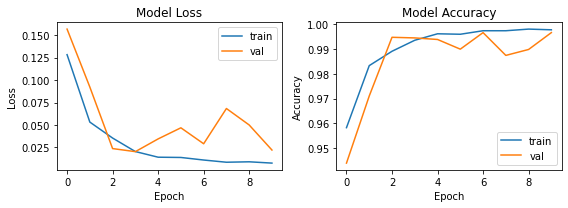

In [193]:
plt.clf()
plt.figure(figsize=(8,3))

# 훈련 손실 그래프
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

# 훈련 정확도 그래프
plt.subplot(122)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.tight_layout()
plt.show()

In [174]:
model.save_weights('kogpt2.keras')

In [181]:
test_datas = test_data['Text'].to_list()

In [183]:
X_test = convert_examples_to_features2(test_datas, max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 500/500 [00:00<00:00, 990.65it/s] 


In [185]:
# 예측 수행
predictions = model.predict(X_test)

# 예측 결과가 클래스 확률일 경우
predicted_classes = np.argmax(predictions, axis=1)

In [186]:
predicted_classes

array([1, 2, 2, 2, 3, 0, 0, 3, 4, 1, 0, 3, 2, 2, 2, 0, 0, 3, 0, 3, 0, 3,
       3, 1, 1, 2, 3, 3, 2, 4, 1, 0, 3, 1, 3, 3, 3, 0, 0, 1, 0, 3, 2, 1,
       3, 2, 3, 3, 3, 0, 1, 3, 1, 2, 2, 3, 3, 3, 3, 3, 1, 3, 4, 3, 2, 0,
       3, 3, 3, 0, 0, 2, 3, 2, 0, 3, 3, 1, 2, 4, 3, 0, 3, 0, 0, 0, 1, 3,
       1, 2, 0, 2, 0, 3, 3, 2, 4, 2, 0, 2, 0, 1, 3, 2, 3, 2, 2, 3, 3, 0,
       3, 0, 0, 3, 3, 1, 3, 2, 2, 4, 4, 3, 1, 1, 1, 1, 2, 4, 1, 3, 3, 3,
       3, 3, 0, 0, 3, 0, 3, 1, 3, 3, 1, 3, 2, 0, 0, 0, 0, 3, 1, 3, 0, 1,
       2, 3, 0, 2, 3, 3, 0, 3, 4, 0, 2, 3, 2, 3, 3, 1, 0, 2, 2, 1, 3, 3,
       0, 2, 3, 0, 2, 3, 1, 3, 3, 1, 0, 0, 1, 0, 0, 3, 3, 2, 1, 3, 3, 4,
       0, 2, 2, 0, 3, 3, 0, 3, 2, 1, 2, 2, 4, 3, 3, 2, 1, 4, 3, 3, 1, 0,
       1, 2, 3, 4, 0, 4, 4, 0, 1, 0, 2, 0, 3, 0, 1, 3, 3, 1, 1, 3, 3, 3,
       3, 2, 3, 1, 2, 3, 2, 0, 1, 3, 0, 2, 0, 1, 4, 2, 1, 2, 4, 2, 1, 3,
       4, 3, 3, 4, 3, 3, 0, 3, 0, 2, 3, 2, 2, 3, 2, 1, 1, 0, 3, 2, 4, 2,
       0, 2, 1, 3, 1, 1, 3, 3, 2, 3, 0, 3, 1, 0, 4,

In [188]:
submission_data = data_import('submission.csv')

In [190]:
# submission 넣기

submission = pd.DataFrame({"idx" : submission_data.idx, "class" : predicted_classes})
submission.to_csv("submission1.csv",index=False, encoding='utf-8-sig')

submission.head()

,idx,class
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,2
4,t_004,3


In [ ]:
# 예측 결과를 test 데이터프레임에 추가
test_data['predictions'] = predicted_classes
test_data.to_csv("test.csv",index=False, encoding='utf-8-sig')


# 결과 출력
test_data.head()

In [ ]:
test_data.sample(10)

생성 데이터로 다시 해보면 좋을 듯 하다